In [1]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter, AalenAdditiveFitter
from lifelines.utils import concordance_index as lifelines_c_index
from sksurv.metrics import concordance_index_censored as sksurv_c_index
from sksurv.ensemble import RandomSurvivalForest
from sklearn.svm import SVC
import xgboost as xgb
import pandas as pd
import numpy as np

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
file_path = './survival_results'

X = pd.read_csv(f'{file_path}/scaled_genes_age_meno_risk.csv', index_col=0)
y = pd.read_csv(f'{file_path}/survival_time_event.csv',index_col=0)

print(X.shape, y.shape)

# survival_threshold = y['Time to event if any (days)'].median()

survival_thresholds = [365, 1095, 1825]

X_scaled = X.copy()

lifelines_df = pd.concat([X_scaled, y], axis=1)
print(X_scaled.shape, y.shape, lifelines_df.shape)

y_classifications = {}
for threshold in survival_thresholds:
    y_classifications[threshold] = np.where(
        (lifelines_df['Time to event if any (days)'] <= threshold) & (lifelines_df['IDFS Event'] == 1), 1, 0
    )

y_survival = np.array(
    list(zip(y['IDFS Event'].astype(bool), y['Time to event if any (days)'])),
    dtype=[('status', 'bool'), ('time', 'f8')]
)

# train_df_control = pd.read_csv(f'{file_path}/control_train.csv', index_col=0)
# X_train = train_df_control.iloc[:, :20] #gene exp
# Y_train = train_df_control.iloc[:, 20:22] #survival time and event

# invalid_count = (Y_train['time'] <= 0).sum()
# valid_mask = Y_train['time'] > 0

# X_filtered = X_train.loc[valid_mask].copy()
# y_filtered = Y_train.loc[valid_mask].copy()

# X = X_filtered
# y = y_filtered

# print(X.shape, y.shape)

(150, 126) (150, 2)
(150, 126) (150, 2) (150, 128)


In [32]:
corr_matrix = X_scaled.iloc[:, :-5].corr()

In [33]:
corr_matrix

,SERINC1,WDR6,INTS3,PIP5K1A,TMEM259,ARGLU1,NXF1,SNX3,KAT2A,CLCN7,...,CDC42EP4,CAPRIN1,MBOAT1,FYCO1,UBE2R2,LRRC56,OGT,EEF1D,USP36,MZF1
SERINC1,1.000000,-0.172732,-0.093799,-0.122856,-0.174651,0.053855,-0.043654,0.276466,-0.238706,-0.179661,...,-0.148826,0.200307,-0.022103,0.099105,0.057743,-0.082235,0.022013,-0.354632,-0.229714,-0.103266
WDR6,-0.172732,1.000000,0.577237,0.279912,0.696359,0.448571,0.561998,-0.290671,0.572234,0.636988,...,-0.027839,-0.168262,0.378032,0.474941,-0.004674,0.518919,0.395395,0.185210,0.351440,0.412103
INTS3,-0.093799,0.577237,1.000000,0.478613,0.516420,0.466704,0.536788,-0.195078,0.579536,0.488117,...,-0.055599,-0.060915,0.339197,0.523871,0.227114,0.451459,0.435455,0.087532,0.248910,0.354357
PIP5K1A,-0.122856,0.279912,0.478613,1.000000,0.200280,0.225765,0.256175,-0.006191,0.275989,0.236888,...,0.004436,0.013792,0.269515,0.264189,0.161487,0.271799,0.296187,0.239032,0.173570,0.198272
TMEM259,-0.174651,0.696359,0.516420,0.200280,1.000000,0.353737,0.517455,-0.312920,0.640167,0.677274,...,0.013661,-0.127830,0.223767,0.428254,-0.015699,0.426404,0.322189,0.190051,0.364805,0.309097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LRRC56,-0.082235,0.518919,0.451459,0.271799,0.426404,0.181972,0.264752,-0.285053,0.289961,0.503162,...,-0.092785,0.059273,0.289850,0.313713,0.004330,1.000000,0.142354,0.179703,0.161988,0.169037
OGT,0.022013,0.395395,0.435455,0.296187,0.322189,0.695739,0.517629,-0.031869,0.343732,0.278583,...,-0.062122,-0.157961,0.219289,0.264721,-0.048748,0.142354,1.000000,-0.062840,0.310782,0.364518
EEF1D,-0.354632,0.185210,0.087532,0.239032,0.190051,-0.092754,0.041793,-0.205536,0.250463,0.210431,...,0.250422,0.006708,0.091475,-0.024564,-0.092087,0.179703,-0.062840,1.000000,0.432892,0.151706
USP36,-0.229714,0.351440,0.248910,0.173570,0.364805,0.292013,0.243565,-0.166757,0.376322,0.265437,...,0.264154,-0.168722,0.241095,0.068065,-0.160294,0.161988,0.310782,0.432892,1.000000,0.258778


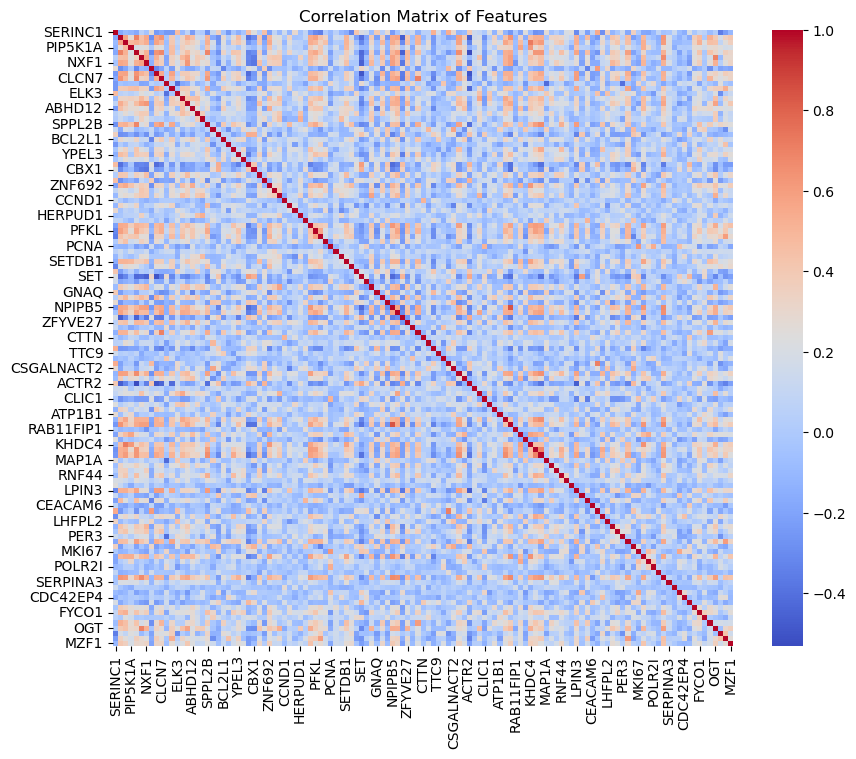

high correlation pairs:
Series([], dtype: bool)


In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Features')
plt.show()

high_corr_pairs = (corr_matrix.abs() > 0.9) & (corr_matrix.abs() < 1.0)
high_corr_indices = high_corr_pairs.stack()[high_corr_pairs.stack()]

print("high correlation pairs:")
print(high_corr_indices)

In [38]:
models_and_params = {
    'RandomForest': {
        'model': RandomSurvivalForest(n_estimators=100, random_state=42),
        'param_grid': {'max_depth': [3, 5]}
    },
    'SVM': {
        'model': SVC(random_state=42, class_weight='balanced'),
        'param_grid': {'C': [0.1, 1], 'kernel': ['linear']}
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'param_grid': {'n_estimators': [50, 100], 'max_depth': [3, 5]}
    }
}

In [43]:
num_repeats = 20
k_folds = 4

c_index_results = {
    'RandomForest': [],
    'CoxPH': [],
    'Aalen': [],
    'SVM_1y': [],
    'SVM_3y': [],
    'SVM_5y': [],
    'XGBoost_1y': [],
    'XGBoost_3y': [],
    'XGBoost_5y': []
}
for run in range(num_repeats):
    print(f"\n--- No. {run + 1}/{num_repeats} ---")
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=run)

    for model_name, config in models_and_params.items():
        if model_name in ['RandomForest']:
            print(f"Fine-tuning and evaluating: {model_name}")
            fold_c_indices = []
            for train_idx, test_idx in kf.split(X_scaled, y_survival):
                X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
                y_train = y_survival[train_idx]
                y_test = y_survival[test_idx]
                config['model'].fit(X_train, y_train)
                predictions = config['model'].predict(X_test)
                c_index = sksurv_c_index(y_test['status'], y_test['time'], predictions)[0]
                fold_c_indices.append(c_index)
            c_index_results[model_name].append(np.mean(fold_c_indices))
            print(f'Finished {run + 1}/{num_repeats} for {model_name} with C-index: {np.mean(fold_c_indices):.4f}')
        else: # SVM and XGBoost
            for threshold in survival_thresholds:
                y_classification = y_classifications[threshold]
                key_name = f'{model_name}_{int(threshold/365)}y'
                print(f"Fine-tuning and evaluating: {model_name} with threshold {threshold} days")
                
                fold_c_indices = []
                for train_idx, test_idx in kf.split(X_scaled, y_classification):
                    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
                    y_train = y_classification[train_idx]
                    y_test = y_classification[test_idx]
                    gscv = GridSearchCV(config['model'], config['param_grid'], cv=KFold(n_splits=k_folds, shuffle=True, random_state=run), n_jobs=-1)
                    gscv.fit(X_train, y_train)
                    best_model = gscv.best_estimator_
                    predictions = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test)
                    c_index = lifelines_c_index(lifelines_df.iloc[test_idx]['Time to event if any (days)'], predictions, lifelines_df.iloc[test_idx]['IDFS Event'])
                    fold_c_indices.append(c_index)
                c_index_results[key_name].append(np.mean(fold_c_indices))
                print(f'Finished {run + 1}/{num_repeats} for {model_name} (threshold {threshold}) with C-index: {np.mean(fold_c_indices):.4f}')

    # --- 评估 Cox 和 Aalen 模型 (无需调参) ---
    print("\nEvaluating CoxPH...")
    cox_scores = []
    for train_idx, test_idx in kf.split(lifelines_df):
        train_df = lifelines_df.iloc[train_idx]
        test_df = lifelines_df.iloc[test_idx]
        cph = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
        cph.fit(train_df, duration_col='Time to event if any (days)', event_col='IDFS Event', show_progress=False)
        predictions = cph.predict_partial_hazard(test_df)
        c_index = lifelines_c_index(test_df['Time to event if any (days)'], predictions, test_df['IDFS Event'])
        cox_scores.append(c_index)
    c_index_results['CoxPH'].append(np.mean(cox_scores))
    print(f'Finished {run + 1}/{num_repeats} for CoxPH with C-index: {np.mean(cox_scores):.4f}')

    print("Evaluating Aalen...")
    aalen_scores = []
    for train_idx, test_idx in kf.split(lifelines_df):
        train_df = lifelines_df.iloc[train_idx]
        test_df = lifelines_df.iloc[test_idx]
        try:
            aaf = AalenAdditiveFitter(coef_penalizer=0.1)
            aaf.fit(train_df, duration_col='Time to event if any (days)', event_col='IDFS Event', show_progress=False)
            predictions = aaf.predict_cumulative_hazard(test_df)
            c_index = lifelines_c_index(test_df['Time to event if any (days)'], predictions.iloc[:, 0], test_df['IDFS Event'])
        except Exception as e:
            print(f"AalenAdditiveFitter failed to fit. Error: {e}. Appending 0.5 as C-index.")
            c_index = 0.5
        aalen_scores.append(c_index)
    c_index_results['Aalen'].append(np.mean(aalen_scores))
    print(f'Finished {run + 1}/{num_repeats} for Aalen with C-index: {np.mean(aalen_scores):.4f}')

print("\n--- Final C-index Results ---")
print(pd.DataFrame(c_index_results).mean())


--- No. 1/20 ---
Fine-tuning and evaluating: RandomForest
Finished 1/20 for RandomForest with C-index: 0.6871
Fine-tuning and evaluating: SVM with threshold 365 days
Finished 1/20 for SVM (threshold 365) with C-index: 0.3022
Fine-tuning and evaluating: SVM with threshold 1095 days
Finished 1/20 for SVM (threshold 1095) with C-index: 0.3437
Fine-tuning and evaluating: SVM with threshold 1825 days
Finished 1/20 for SVM (threshold 1825) with C-index: 0.3298
Fine-tuning and evaluating: XGBoost with threshold 365 days
Finished 1/20 for XGBoost (threshold 365) with C-index: 0.2987
Fine-tuning and evaluating: XGBoost with threshold 1095 days
Finished 1/20 for XGBoost (threshold 1095) with C-index: 0.3623
Fine-tuning and evaluating: XGBoost with threshold 1825 days
Finished 1/20 for XGBoost (threshold 1825) with C-index: 0.3155

Evaluating CoxPH...
Finished 1/20 for CoxPH with C-index: 0.2683
Evaluating Aalen...
AalenAdditiveFitter failed to fit. Error: Event times and predictions must have t

In [13]:
print(pd.DataFrame(c_index_results).mean())

RandomForest    0.713005
SVM             0.355386
XGBoost         0.327563
CoxPH           0.521439
Aalen           0.500000
dtype: float64


In [24]:
model_performance = {}
for model_name, scores in c_index_results.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    model_performance[model_name] = mean_score
    print(f"{model_name:<15}: average C-index = {mean_score:.4f}, SD = {std_score:.4f}")

# 找出表现最佳的模型
best_model_name = max(model_performance, key=model_performance.get)
print(f"\n the best model is: {best_model_name}, the average C-index is {model_performance[best_model_name]:.4f}")

RandomForest   : average C-index = 0.7663, SD = 0.0071
SVM            : average C-index = 0.8352, SD = 0.0141
XGBoost        : average C-index = 0.7624, SD = 0.0087
CoxPH          : average C-index = 0.1525, SD = 0.0016
Aalen          : average C-index = 0.3210, SD = 0.0076

 the best model is: SVM, the average C-index is 0.8352


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.violinplot(x='Model', y='C-index Score', data=c_index_results['Aalen'], palette='Paired')

TypeError: Data source must be a DataFrame or Mapping, not <class 'list'>.

<Figure size 1200x700 with 0 Axes>

In [27]:
c_index_results['Aalen']

[np.float64(0.3210507429354246),
 np.float64(0.3104631803810038),
 np.float64(0.31393250508518705),
 np.float64(0.32255369820541013),
 np.float64(0.3328201446317648),
 np.float64(0.3189149731054562),
 np.float64(0.3153881004166126),
 np.float64(0.31437230044764153),
 np.float64(0.334943043281681),
 np.float64(0.3274156359360302),
 np.float64(0.32901252338228426),
 np.float64(0.3151980756974564),
 np.float64(0.3151959139022626),
 np.float64(0.31578908481599965),
 np.float64(0.30754448365202436),
 np.float64(0.3296278033766177),
 np.float64(0.32433424290395646),
 np.float64(0.3175508225062155),
 np.float64(0.33055223793530536),
 np.float64(0.3237078505218781)]